In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def bspline_wavelet(x, omega, alpha=1):
    return (
        (1 / 6) * F.relu(omega * x) -
        (4 / 3) * F.relu(omega * x - 0.5) +
        (23 / 6) * F.relu(omega * x - 1) -
        (16 / 3) * F.relu(omega * x - 1.5) +
        (23 / 6) * F.relu(omega * x - 2) -
        (4 / 3) * F.relu(omega * x - 2.5) +
        (1 / 6) * F.relu(omega * x - 3)
    ) * alpha

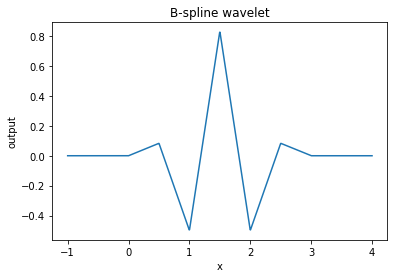

In [29]:
omega = 1
alpha = 1
lower = -1 / omega
upper = 4 / omega


x = torch.linspace(lower, upper, 1000)
y = bspline_wavelet(x, omega, alpha)
plt.plot(x, y)
plt.title('B-spline wavelet')
plt.xlabel('x')
plt.ylabel('output')
plt.show()
